In [1]:
import pandas as pd # used for reading csv and data cleaning
import numpy as np # used for linspace and interp
import re #regex for preprocessing
import string #for string operations
# sklearn for various operations 
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
# matplotlib for plotting 
import matplotlib.pylab as plt
import matplotlib.patches as patches

In [2]:
#for suprressing unnecessary warnings
import sys
if not sys.warnoptions:
    import warnings
    warnings.filterwarnings("ignore")

In [3]:
#reading data
data = pd.read_csv('sentiment.tsv', delimiter='\t', header=None)

In [4]:
#giving proper names to columns
data.columns = ['label', 'tweet']

In [5]:
#data glance
data.head()

,label,tweet
0,neg,"@jamielewislewis i cant believe it, it really ..."
1,pos,having a vodka tonic and looking forward to go...
2,pos,@ddlovatofans1neg1 Could you follow me please....
3,pos,@jordanknight for once.................. PLEAS...
4,neg,Had a dream about a walk in fast food resturau...


In [6]:
#No class imbalanced dataset
data['label'].value_counts()

pos    1016
neg     985
Name: label, dtype: int64

In [7]:
#using basic approach of tf-idf basically tf-idf does not cover context 
# but we will know about data nature after results

In [8]:
# pip install stop-words

In [9]:
# importing stopwords for removing them while preprocessing
from stop_words import get_stop_words
stop_words = get_stop_words('english')

In [10]:
#this function will remove unwanted text of special characters
def preprocess_text(text):
    text = str(text).lower()
    text = text.replace('\n', ' ')
    text = ' '.join([word for word in text.split(' ') if word not in stop_words])
    text = text.encode('ascii', 'ignore').decode()
    text = re.sub(r'https*\S+', ' ', text)
    text = re.sub(r'@\S+', ' ', text)
    text = re.sub(r'#', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    return text

In [11]:
#preprocessing tweet with function using apply and lambda method
data['processed_tweet'] = data['tweet'].apply(lambda x: preprocess_text(x))
# label encoding, changing the categorical value to numerical values
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(data['label'])
encoded_label = label_encoder.transform(data['label'])

In [21]:
#TfidfVectorizer will create an object with specific parameter to convert text into numericals
tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=1, max_features=25000, norm='l2', 
                               encoding='latin-1', ngram_range=(1, 4), stop_words='english')
tfidf_vectorizer.fit(data['processed_tweet'])
#applying vectorizer on processed tweet column
tfidf_feature= tfidf_vectorizer.transform(data['processed_tweet'])

In [22]:
#creating stratified(balanced split over all classes) kfold object
cv_kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
# cnt = 1
# # split()  method generate indices to split data into training and test set.
# for train_index, test_index in kf.split(data_text_feature, enoded_train_label):
#     print(f'Fold:{cnt}, Train set: {len(train_index)}, Test set:{len(test_index)}')
#     cnt+=1

In [23]:
#defining x(features) and y(target variables)
x = tfidf_feature
y = encoded_label

In [24]:
#defining random forest classifier model
clf_model = RandomForestClassifier(n_estimators=256,
    criterion='gini',
    max_depth=7,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=-1,
    random_state=20012,
    verbose=0,
    warm_start=True,)

for 1 fold auc score is  0.7385125767478709
for 2 fold auc score is  0.9119911991199121
for 3 fold auc score is  0.9264926492649265
for 4 fold auc score is  0.9297429742974298
for 5 fold auc score is  0.9327432743274328
for 6 fold auc score is  0.8992597038815525
for 7 fold auc score is  0.9285214085634252
for 8 fold auc score is  0.9133153261304522
for 9 fold auc score is  0.9333233293317327
for 10 fold auc score is  0.9495298119247699


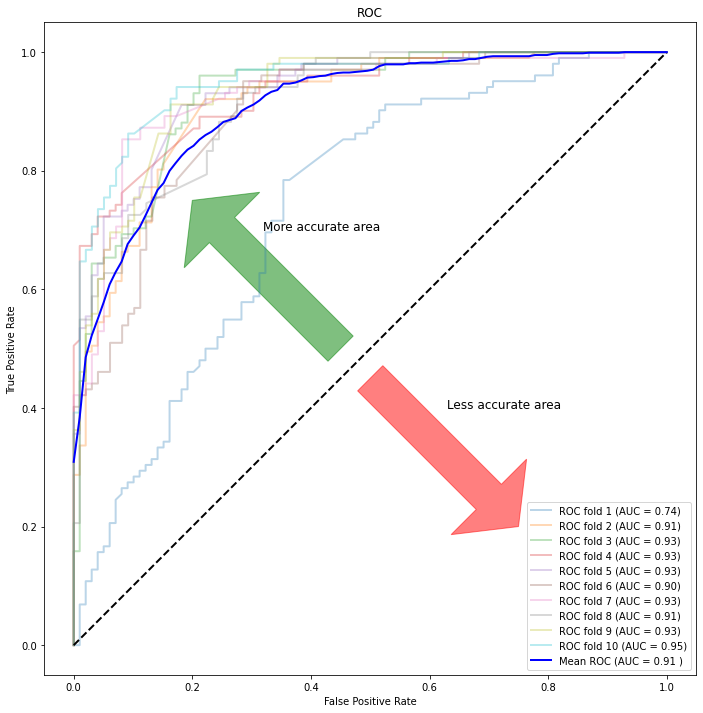

In [25]:
# creating a figure for plot
fig1 = plt.figure(figsize=[12,12])
#adding a sub plot for arrows
ax1 = fig1.add_subplot(111,aspect = 'equal')
# adding arrows
ax1.add_patch(
    patches.Arrow(0.45,0.5,-0.25,0.25,width=0.3,color='green',alpha = 0.5)
    )
ax1.add_patch(
    patches.Arrow(0.5,0.45,0.25,-0.25,width=0.3,color='red',alpha = 0.5)
    )
#list to store results from every kfold model training 
tprs = []
aucs = []
score_ = []
mean_fpr = np.linspace(0,1,100)
i = 1
for train,test in cv_kf.split(x,y):
    #getting prediction after model training
    prediction = clf_model.fit(x[train],y[train]).predict_proba(x[test])
    #calculating score directly using sklearn function
    score_.append(roc_auc_score(y[test], prediction[:, 1]))
    print('for {} fold auc score is '.format(i), roc_auc_score(y[test], prediction[:, 1]))
    #calculating false positive rate, true positive rate and threshold using roc_curve from sklearn
    fpr, tpr, t = roc_curve(y[test], prediction[:, 1]) 
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    #getting area under curve
    roc_auc = auc(fpr, tpr)
    #appending roc_auc for calculating mean auc
    aucs.append(roc_auc)
    #plotting for every kfold model
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i= i+1
#adding a dotted seperator 
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
#calculating mean tpr and auc
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
#final mean graph with mean values
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)
#adding text(x axis and yaxis labels) to make it self explainatory
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
#fixing legend table position
plt.legend(loc="lower right")
#hard coded text for arrows
plt.text(0.32,0.7,'More accurate area',fontsize = 12)
plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
plt.show()